In [1]:
# import the general stuff
import os
from os import getcwd
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
from sklearn import metrics

#import stuff for gradCAM
import matplotlib.cm as cm
from IPython.display import Image

#import the tf stuff
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model

from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Check TensorFlow Version
print('TF version: {}' .format(tf.__version__))

TF version: 2.3.0


In [2]:
#Check for GPU utilization
if tf.test.gpu_device_name():
    print(' GPU: {}'.format(tf.test.gpu_device_name()))
else:
    print("No GPU")

 GPU: /device:GPU:0


In [7]:
# define a callback

callbacks = tf.keras.callbacks.EarlyStopping(monitor = 'val_acc', 
                                             patience = 30, 
                                             restore_best_weights = True)

In [3]:
# Define dirs and files
train_dir = '../data/training/'
validation_dir = '../data/validation/'

train_wash_dir = os.path.join(train_dir,'wash')
train_nowash_dir = os.path.join(train_dir,'nowash')
validation_wash_dir = os.path.join(validation_dir,'wash')
validation_nowash_dir = os.path.join(validation_dir,'nowash')

train_wash_fnames = os.listdir(train_wash_dir)
train_nowash_fnames = os.listdir(train_nowash_dir)
validation_wash_fnames = os.listdir(validation_wash_dir)
validation_nowash_fnames = os.listdir(validation_nowash_dir)


print(len(os.listdir(train_wash_dir)))
print(len(os.listdir(train_nowash_dir)))
print(len(os.listdir(validation_wash_dir)))
print(len(os.listdir(validation_nowash_dir)))

total_train=len(os.listdir(train_wash_dir))+ len(os.listdir(train_nowash_dir))
total_val=len(os.listdir(validation_wash_dir))+ len(os.listdir(validation_nowash_dir))

143
167
36
42


In [4]:
#build data generators for training and validaton

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator( rescale =1./255.,
                                   rotation_range = 90,
                                   width_shift_range = 0.5,
                                   height_shift_range = 0.5,
                                   shear_range = 0.45,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   vertical_flip = True)

# rescale val data
val_datagen = ImageDataGenerator( rescale =1./255.,
                                   rotation_range = 90,
                                   width_shift_range = 0.5,
                                   height_shift_range = 0.5,
                                   shear_range = 0.45,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   vertical_flip = True)

#set batch Size
batch_size = 8

#set Image size (RGB so imshape is 3)
pix_dim = 416
imsize = (pix_dim,pix_dim) 
imshape = (pix_dim,pix_dim,3)

# Flow training images in batches 
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = batch_size,
                                                    class_mode = 'binary',
                                                    target_size = imsize)

# Flow validation images in batches 
validation_generator =  val_datagen.flow_from_directory( validation_dir,
                                                         batch_size = batch_size,
                                                         class_mode = 'binary',
                                                         target_size = imsize)


Found 310 images belonging to 2 classes.
Found 78 images belonging to 2 classes.


In [20]:
# define the metrics
acc_metric = tf.keras.metrics.BinaryAccuracy(name='acc')

In [21]:
#base model, no top layer, w/ imagenet weights
base_model = tf.keras.applications.VGG16(input_shape = imshape, 
                                             include_top = False, 
                                             weights = 'imagenet')

base_model.trainable = True
base_model.summary()


Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 416, 416, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 416, 416, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 416, 416, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 208, 208, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 208, 208, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 208, 208, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 104, 104, 128)     0     

In [22]:
# add a new classifcation layer

final_layer = base_model.get_layer('block5_pool')
print('shape of last layer is ', final_layer.output_shape)
final_base_output = final_layer.output


#add the last layer
# Flatten the output layer to 1 dimension
x = layers.Flatten()(final_base_output )
# Add a fully connected layer with 1,024 hidden units and ReLU activation
# x = layers.Dense(1024, activation='relu', kernel_regularizer = 'l2')(x)
x = layers.Dense(1024, activation='relu', kernel_regularizer = tf.keras.regularizers.l2(1e-4))(x)
# x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)           

model = Model(base_model.input, x) 

model.summary()

shape of last layer is  (None, 13, 13, 512)
Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 416, 416, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 416, 416, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 416, 416, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 208, 208, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 208, 208, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 208, 208, 128)     147584    
_________________________________________________________________
block2_poo

In [23]:
#build the model
model.compile(loss = 'binary_crossentropy',
              optimizer = tf.keras.optimizers.RMSprop(lr = 1e-5, decay = 1e-5),
              metrics = acc_metric)

In [24]:
#train the model
history = model.fit(train_generator,
                              steps_per_epoch = total_train // batch_size,
                              validation_data = validation_generator,
                              epochs= 200,
                              validation_steps =  total_val // batch_size,
                              callbacks =[callbacks])

Epoch 1/200
38/38 [==============================] - 77s 2s/step - loss: 0.8406 - acc: 0.6722 - val_loss: 0.7377 - val_acc: 0.7083
Epoch 2/200
38/38 [==============================] - 79s 2s/step - loss: 0.6134 - acc: 0.8046 - val_loss: 0.4950 - val_acc: 0.8472
Epoch 3/200
38/38 [==============================] - 81s 2s/step - loss: 0.5705 - acc: 0.8146 - val_loss: 0.4555 - val_acc: 0.8750
Epoch 4/200
38/38 [==============================] - 80s 2s/step - loss: 0.5743 - acc: 0.8179 - val_loss: 0.4857 - val_acc: 0.8472
Epoch 5/200
38/38 [==============================] - 80s 2s/step - loss: 0.4950 - acc: 0.8411 - val_loss: 1.9262 - val_acc: 0.5694
Epoch 6/200
38/38 [==============================] - 80s 2s/step - loss: 0.5184 - acc: 0.8344 - val_loss: 0.4483 - val_acc: 0.8472
Epoch 7/200
38/38 [==============================] - 81s 2s/step - loss: 0.4956 - acc: 0.8278 - val_loss: 0.4119 - val_acc: 0.8750
Epoch 8/200
38/38 [==============================] - 81s 2s/step - loss: 0.4733 - a

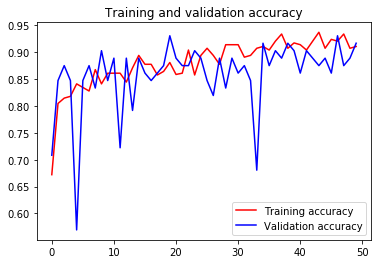

<Figure size 432x288 with 0 Axes>

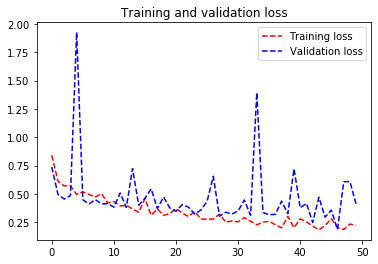

<Figure size 432x288 with 0 Axes>

In [25]:
#look at the metrics from training
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

plt.plot(epochs, loss, 'r--', label='Training loss')
plt.plot(epochs, val_loss, 'b--', label='Validation loss')
plt.title('Training and validation loss') 
plt.legend(loc=0)
plt.figure()
plt.show()

In [5]:
#save the model
filepath = './saved_VGG16_retrain_slower'
model.save(filepath)

#load model
#model = tf.keras.models.load_model(filepath, compile = True)